### homework 2 - part 2

the goal of this part is to build a CNN that where both the input and the output are images

the dataset is made from the dogs vs. cats dataset
https://www.kaggle.com/c/dogs-vs-cats

but its just the cats.

the dataloader adds random noise to the image, and the network task is to remove that noise, recovering the original image

download the cat image dataset from this link:

In [ ]:
!wget https://www.dropbox.com/s/z90tvet2q97n350/cats.npy

In [ ]:
%load_ext autoreload
%autoreload 2

(if its not avaliable on your system, install scikit-image)


https://scikit-image.org/docs/dev/install.html


In [ ]:
#pip install scikit-image

In [ ]:
from cats_dataloader import CatsWithNoiseDataset

In [ ]:
train_ds = CatsWithNoiseDataset('cats.npy',0,800)
valid_ds = CatsWithNoiseDataset('cats.npy',800,1000)

In [ ]:
import matplotlib.pyplot as plt

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


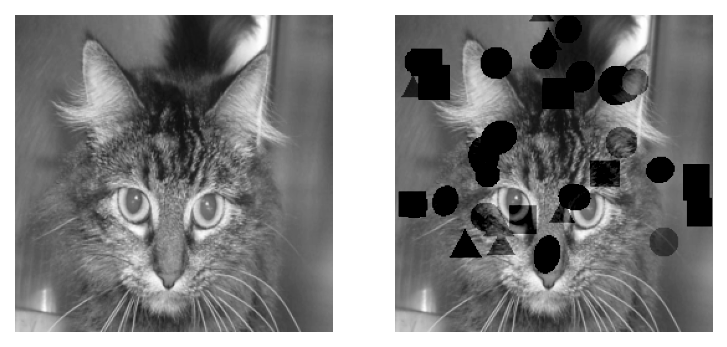

In [ ]:
x, y = train_ds[433]
print(x.shape,y.shape)


fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[1].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

training_dataloader = DataLoader(train_ds,batch_size=4,shuffle=True)
valid_dataloader = DataLoader(valid_ds,batch_size=20)

In [ ]:
for x,y in training_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


### we need to build a model that takes the image as input, and outputs an image of the same size

In [ ]:
import torch.nn as nn

conv_layer = nn.Conv2d(1,50,3,padding=1)

In [ ]:
x.shape

torch.Size([4, 1, 256, 256])

In [ ]:
conv_layer(x).shape

torch.Size([4, 50, 256, 256])

#### build something that takes an image as input and returns an image of the same size as output.

IMG_05078C1BBF12-1.jpeg![image.png](attachment:image.png)

In [1]:
from model_denoise import Net

ModuleNotFoundError: ignored

In [ ]:
net = Net()

In [ ]:

net(x).shape

torch.Size([4, 1, 256, 256])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4) 

In [ ]:
def compute_loss(dataloader,net):
    
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x,y in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            pred = net(x)
            
            loss+= loss_func(pred,y).item()
            
    loss = loss/n_batches      
    return loss

In [ ]:
compute_loss(valid_dataloader,net)

0.07863468006253242

In [ ]:

n_epochs = 100


validation_loss_vs_epoch = []


if torch.cuda.is_available():
    net.cuda()

# from tqdm import tqdm
from tqdm.notebook import tqdm

pbar = tqdm(range(n_epochs))
for epoch in pbar:

    if len(validation_loss_vs_epoch) > 1:
        pbar.set_description('val loss:'+'{0:.5f}'.format(validation_loss_vs_epoch[-1]))

# for epoch in range(n_epochs):
    
#     if len(validation_loss_vs_epoch) > 1:
#         print('epoch',epoch,' val loss:'+'{0:.5f}'.format(validation_loss_vs_epoch[-1]) )
    
    
    net.train() # put the net into "training mode"
    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
        optimizer.zero_grad()
        # pred = net(x)
        pred = net(x)  #, True)
        loss = loss_func(pred,y)
        loss.backward()
        optimizer.step()
    
    net.eval() #put the net into evaluation mode
    
    valid_loss =  compute_loss(valid_dataloader,net)
         
    
    validation_loss_vs_epoch.append(valid_loss)
    
    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), 'trained_model.pt')

In [ ]:
net.load_state_dict(torch.load('trained_model.pt',map_location='cpu'))

<All keys matched successfully>

### you can submit if you validation loss is < 0.01

try to get results that look decent

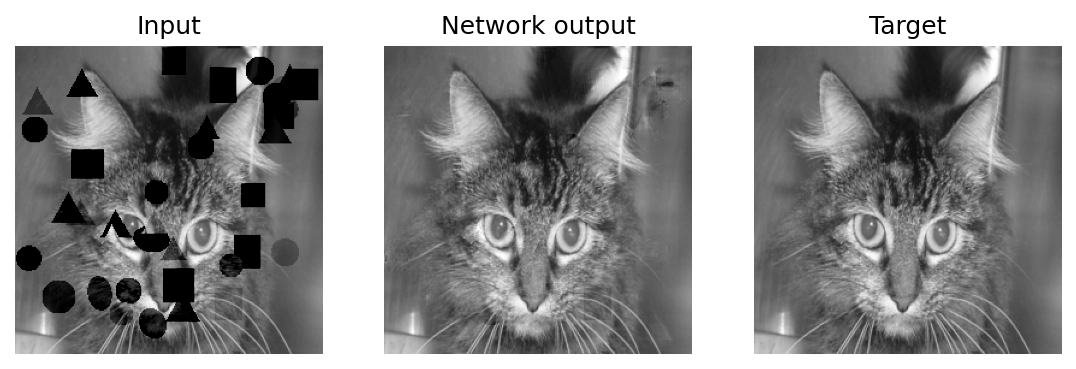

In [ ]:
x, y = train_ds[433]

fig,ax = plt.subplots(1,3,figsize=(9,3),dpi=150)

ax[2].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[0].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

net.eval()
net.cpu()
predicted = net( x.unsqueeze(1) )[0][0].data.numpy()

ax[1].imshow(predicted,cmap='gist_yarg',vmin=0,vmax=1)

ax[0].set_title('Input',fontsize=12)
ax[1].set_title('Network output',fontsize=12)
ax[2].set_title('Target',fontsize=12)
for i in range(3):
    ax[i].set_axis_off()

plt.show()

In [ ]:
from evaluate_cats import evaluate_on_dataset
# execfile('evaluate_cats.py')

evaluate_on_dataset('cats.npy')

In [ ]:
import numpy as np

fig,ax = plt.subplots(figsize=(3,3),dpi=150)


validation_loss_vs_epoch = np.array(validation_loss_vs_epoch)

ax.plot(validation_loss_vs_epoch[:],label='training loss')



plt.show()